In [1]:


import numpy as np 
import pandas as pd 
import os


total 4460
-rw-r--r--  1 nobody nogroup     863 Jun  6 03:15 extract.py
-rw-r--r--  1 nobody nogroup    1037 Jun  6 03:15 labels.csv
-rw-r--r--  1 nobody nogroup 4552523 Jun  6 03:15 model_trained.p
drwxr-xr-x 45 nobody nogroup    4096 Jun  6 03:18 myData


In [2]:
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
%matplotlib inline
from tensorflow.keras.utils import plot_model

# Splitting data
from sklearn.model_selection import train_test_split

# Metrics 
from sklearn.metrics import confusion_matrix, classification_report

# Deep Learning
import tensorflow as tf
print('TensoFlow Version: ', tf.__version__)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.applications.resnet import ResNet50

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

TensoFlow Version:  2.1.0


In [3]:
path = '/kaggle/input/traffic-signs-classification'
lab = pd.read_csv('/kaggle/input/traffic-signs-classification/labels.csv')


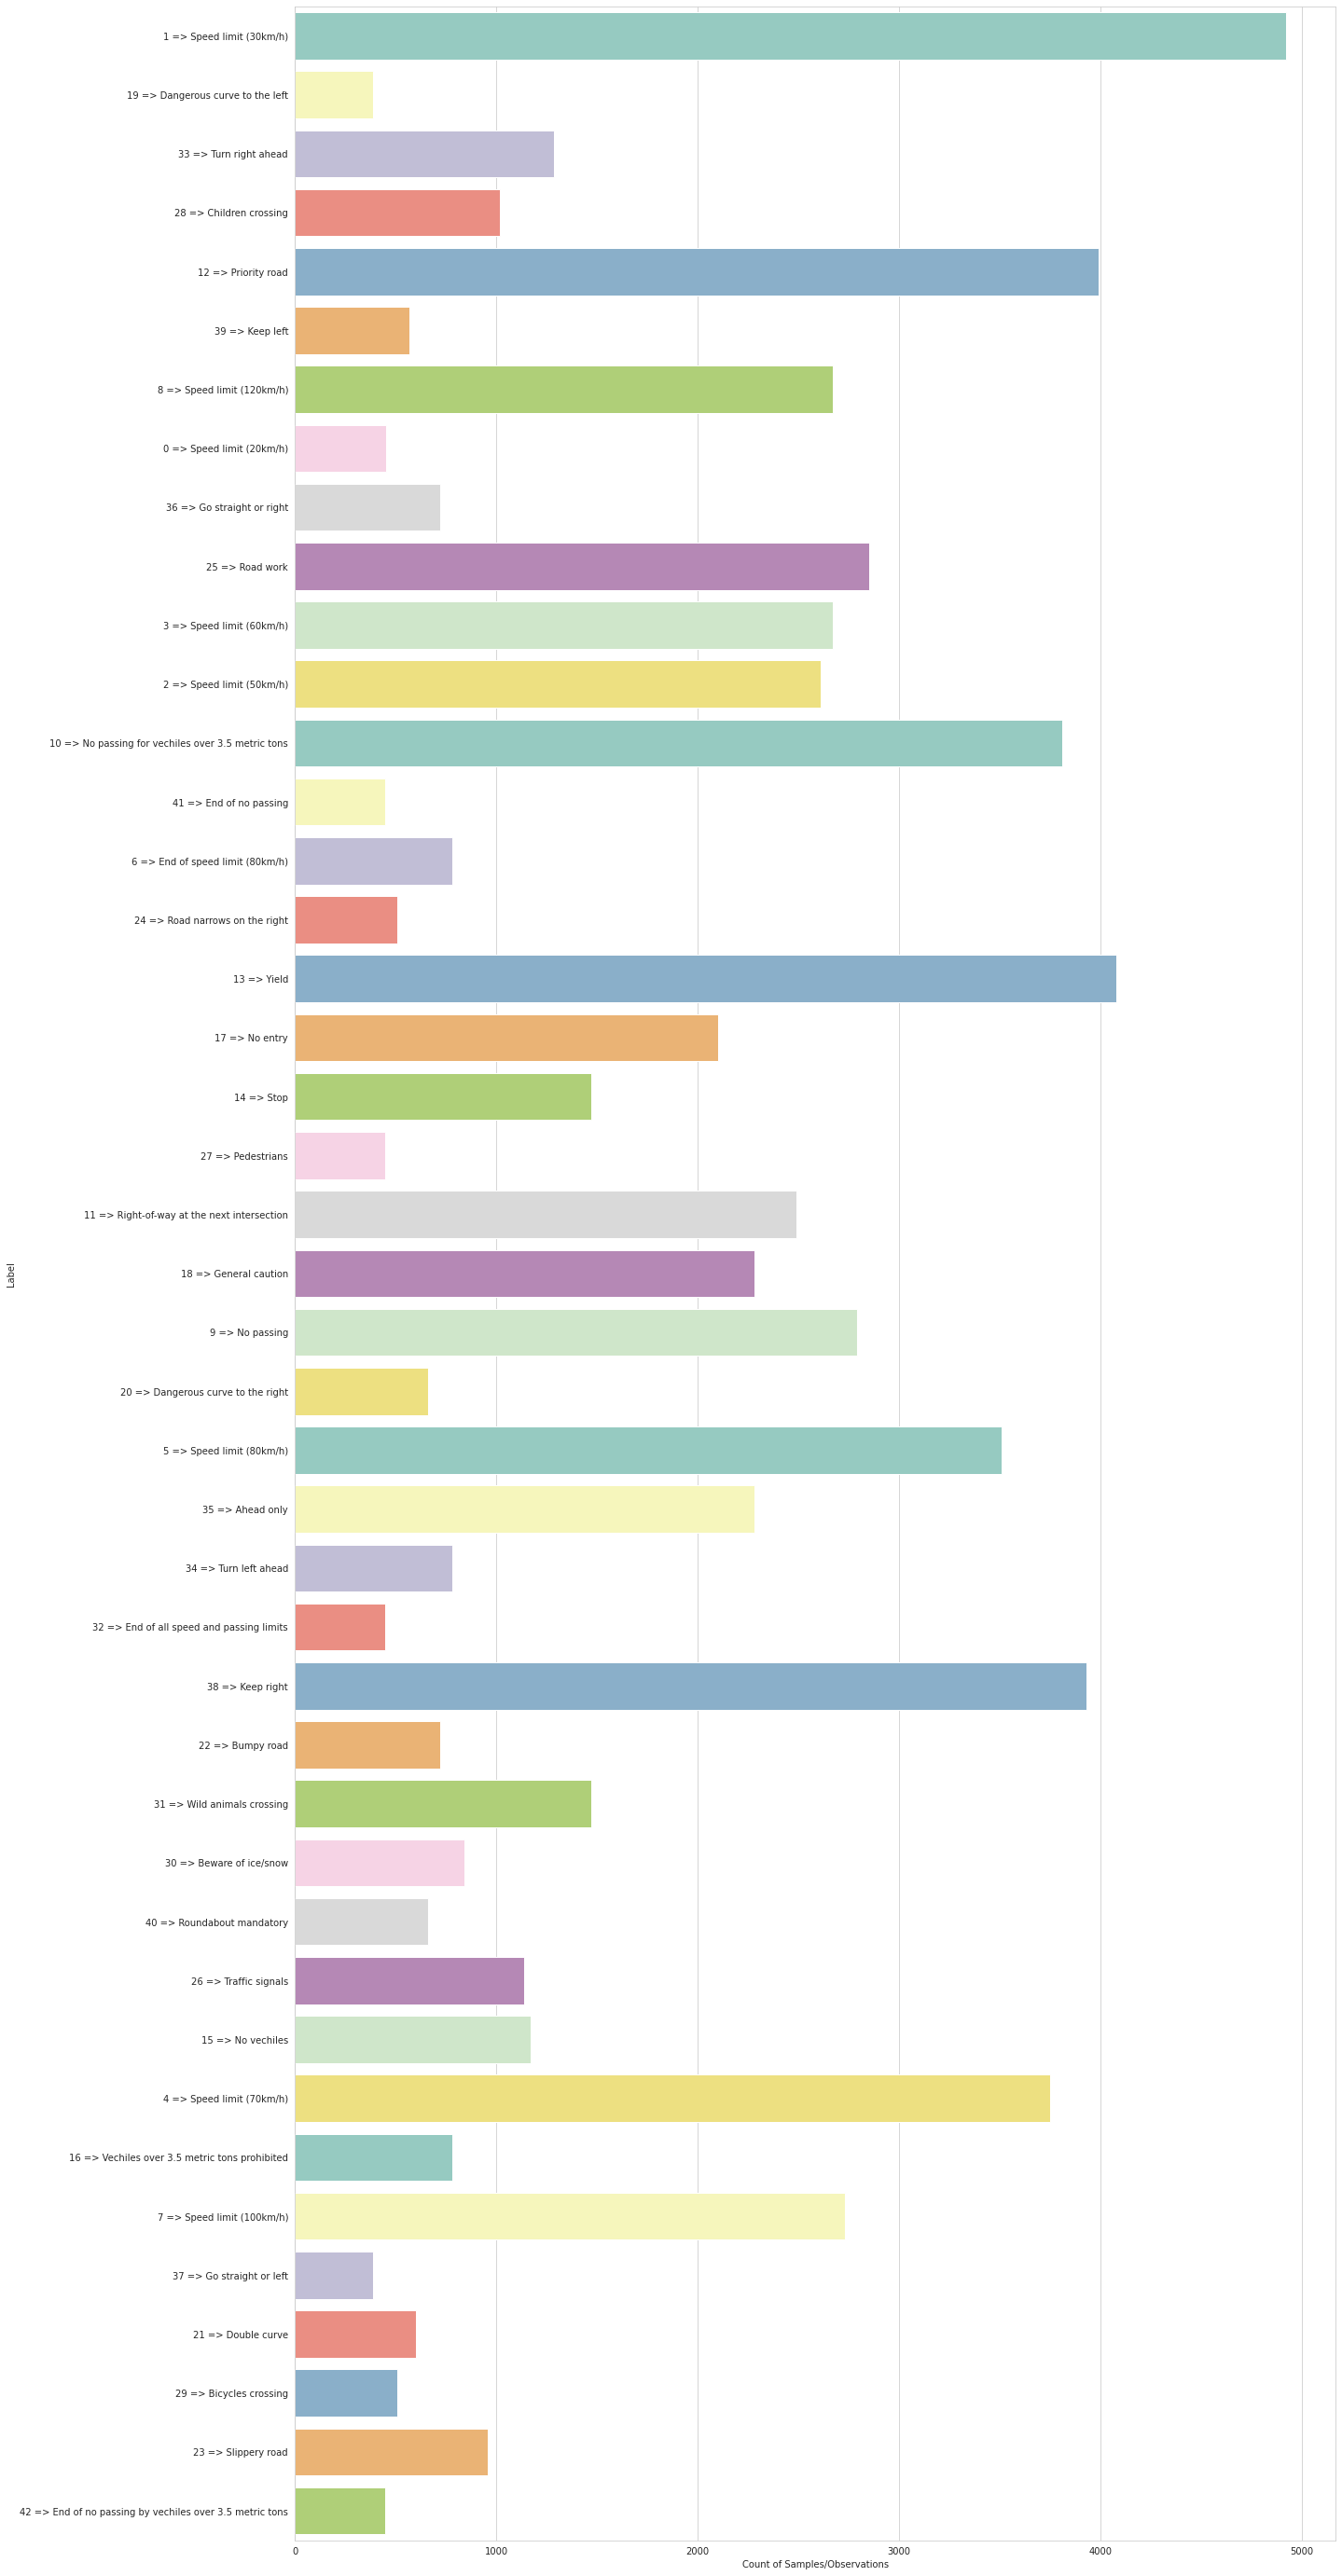

In [4]:
# Count PLot of the samples/observations w.r.t the classes
d = dict()
class_labels = dict()
for dirs in os.listdir(path + '/myData'):
    count = len(os.listdir(path+'/myData/'+dirs))
    d[dirs+' => '+lab[lab.ClassId == int(dirs)].values[0][1]] = count
    class_labels[int(dirs)] = lab[lab.ClassId == int(dirs)].values[0][1]

plt.figure(figsize = (20, 50))
sns.barplot(y = list(d.keys()), x = list(d.values()), palette = 'Set3')
plt.ylabel('Label')
plt.xlabel('Count of Samples/Observations');

In [5]:
# input image dimensions
img_rows, img_cols = 32, 32
# The images are RGB.
img_channels = 3
nb_classes = len(class_labels.keys())

datagen = ImageDataGenerator()
data = datagen.flow_from_directory('/kaggle/input/traffic-signs-classification/myData',
                                    target_size=(32, 32),
                                    batch_size=73139,
                                    class_mode='categorical',
                                    shuffle=True )

Found 73139 images belonging to 43 classes.


In [6]:
X , y = data.next()

In [7]:
# Labels are one hot encoded
print(f"Data Shape   :{X.shape}\nLabels shape :{y.shape}")

Data Shape   :(73139, 32, 32, 3)
Labels shape :(73139, 43)


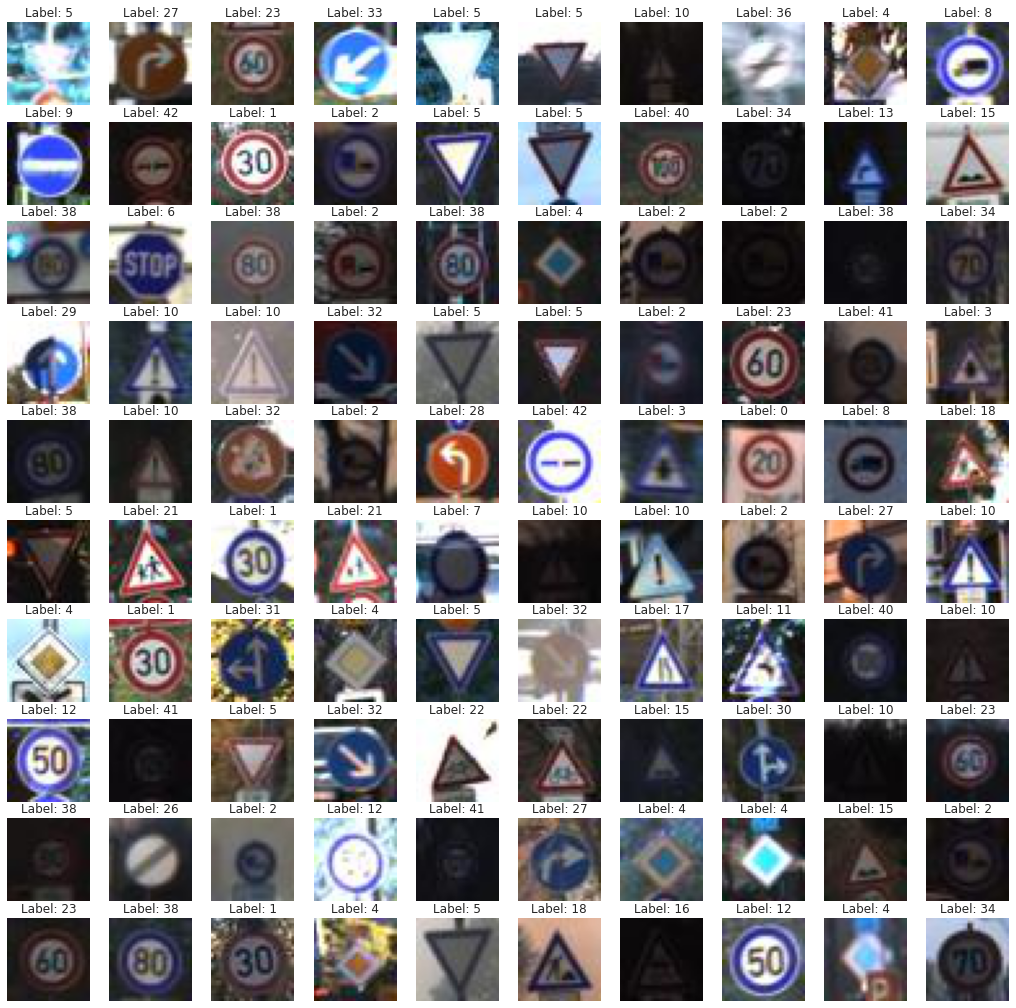

In [8]:
fig, axes = plt.subplots(10,10, figsize=(18,18))
for i,ax in enumerate(axes.flat):
    r = np.random.randint(X.shape[0])
    ax.imshow(X[r].astype('uint8'))
    ax.grid(False)
    ax.axis('off')
    ax.set_title('Label: '+str(np.argmax(y[r])))
    


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11)

In [10]:
print("Train Shape: {}\nTest Shape : {}".format(X_train.shape, X_test.shape))

Train Shape: (58511, 32, 32, 3)
Test Shape : (14628, 32, 32, 3)


In [11]:
resnet = ResNet50(weights= None, include_top=False, input_shape= (img_rows,img_cols,img_channels))

In [12]:
x = resnet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(nb_classes, activation= 'softmax')(x)
model = Model(inputs = resnet.input, outputs = predictions)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [15]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
model_check = ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=0, mode='max', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

csv_logger = CSVLogger('train_log.csv', separator=',')


In [17]:
n_epochs = 50
history =  model.fit(X_train, y_train,  batch_size = 32, epochs = n_epochs, verbose = 1, 
              validation_data = (X_test, y_test), callbacks = [model_check, early, reduce_lr, csv_logger])

Train on 58511 samples, validate on 14628 samples
Epoch 1/50
58511/58511 [==============================] - 88s 2ms/sample - loss: 4.4293 - accuracy: 0.0942 - val_loss: 4.9793 - val_accuracy: 0.0792
Epoch 2/50
58511/58511 [==============================] - 76s 1ms/sample - loss: 4.0415 - accuracy: 0.0882 - val_loss: 7.5414 - val_accuracy: 0.0616
Epoch 3/50
58511/58511 [==============================] - 78s 1ms/sample - loss: 3.7661 - accuracy: 0.0968 - val_loss: 4.3542 - val_accuracy: 0.1265
Epoch 4/50
58511/58511 [==============================] - 77s 1ms/sample - loss: 3.1627 - accuracy: 0.1917 - val_loss: 15.9657 - val_accuracy: 0.3561
Epoch 5/50
58511/58511 [==============================] - 77s 1ms/sample - loss: 1.4248 - accuracy: 0.6216 - val_loss: 0.5162 - val_accuracy: 0.8434
Epoch 6/50
58511/58511 [==============================] - 78s 1ms/sample - loss: 0.6379 - accuracy: 0.8356 - val_loss: 0.7554 - val_accuracy: 0.9290
Epoch 7/50
58511/58511 [==============================]

In [18]:
# Saving the model
model.save('TSC_model.h5')

In [19]:
loss, acc = model.evaluate(X_test, y_test)
print('Accuracy: ', acc, '\nLoss    : ', loss)

14628/14628 [==============================] - 7s 459us/sample - loss: 0.0152 - accuracy: 0.9950
Accuracy:  0.99500954 
Loss    :  0.01519757837016044


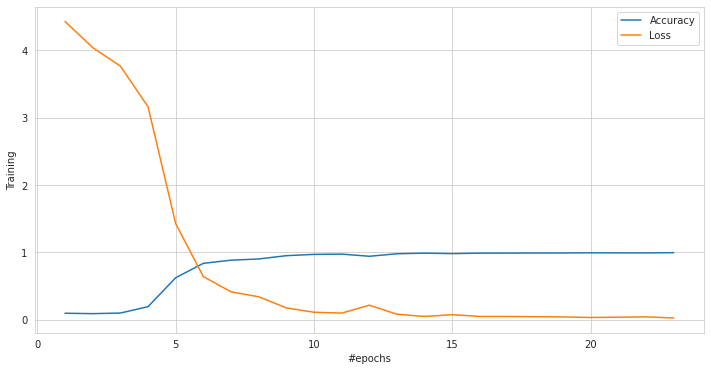

In [20]:
q = len(list(history.history['loss']))
plt.figure(figsize=(12, 6))
sns.lineplot(x = range(1, 1+q), y = history.history['accuracy'], label = 'Accuracy')
sns.lineplot(x = range(1, 1+q), y = history.history['loss'], label = 'Loss')
plt.xlabel('#epochs')
plt.ylabel('Training')
plt.legend();

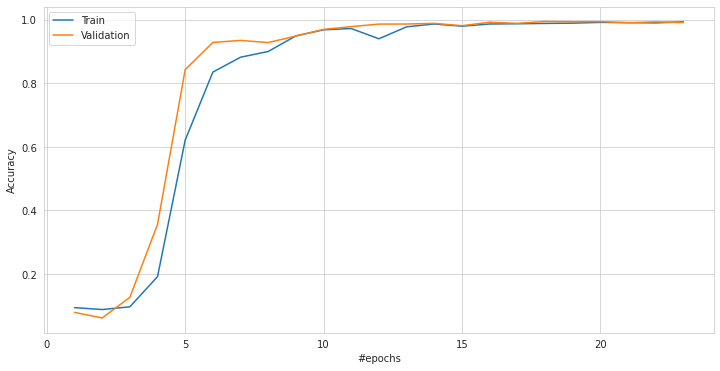

In [21]:
plt.figure(figsize=(12, 6))
sns.lineplot(x = range(1, 1+q), y = history.history['accuracy'], label = 'Train')
sns.lineplot(x = range(1, 1+q), y = history.history['val_accuracy'], label = 'Validation')
plt.xlabel('#epochs')
plt.ylabel('Accuracy')
plt.legend();

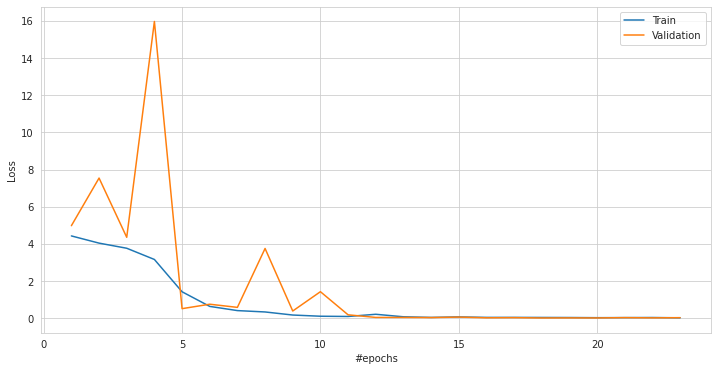

In [22]:
plt.figure(figsize=(12, 6))
sns.lineplot(x = range(1, 1+q), y = history.history['loss'], label = 'Train')
sns.lineplot(x = range(1, 1+q), y = history.history['val_loss'], label = 'Validation')
plt.xlabel('#epochs')
plt.ylabel('Loss')
plt.legend();

In [23]:
%%time
pred = np.argmax(model.predict(X_test), axis = 1)

CPU times: user 6.12 s, sys: 971 ms, total: 7.09 s
Wall time: 6.71 s


In [31]:
labels = [class_labels[i] for i in range(43)]
print(classification_report(np.argmax(y_test, axis = 1), pred, target_names = labels))

                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       1.00      0.97      0.99       113
                              Speed limit (30km/h)       1.00      0.99      0.99       926
                              Speed limit (50km/h)       1.00      0.99      1.00       775
                              Speed limit (60km/h)       0.99      0.99      0.99       506
                              Speed limit (70km/h)       0.99      1.00      1.00       804
                              Speed limit (80km/h)       1.00      1.00      1.00       804
                       End of speed limit (80km/h)       1.00      1.00      1.00       321
                             Speed limit (100km/h)       1.00      1.00      1.00       214
                             Speed limit (120km/h)       1.00      1.00      1.00       164
                                        No passing       1.00      1.00      1.

In [26]:
classwise_acc = cmat.diagonal()/cmat.sum(axis=1) * 100 
cls_acc = pd.DataFrame({'Class_Label':[class_labels[i] for i in range(43)], 'Accuracy': classwise_acc.tolist()}, columns = ['Class_Label', 'Accuracy'])
cls_acc.style.format({"Accuracy": "{:,.2f}",}).hide_index().bar(subset=["Accuracy"], color='tomato')

Class_Label,Accuracy
Speed limit (20km/h),97.35
Speed limit (30km/h),99.03
Speed limit (50km/h),99.48
Speed limit (60km/h),99.41
Speed limit (70km/h),99.75
Speed limit (80km/h),99.88
End of speed limit (80km/h),100.00
Speed limit (100km/h),100.00
Speed limit (120km/h),100.00
No passing,100.00


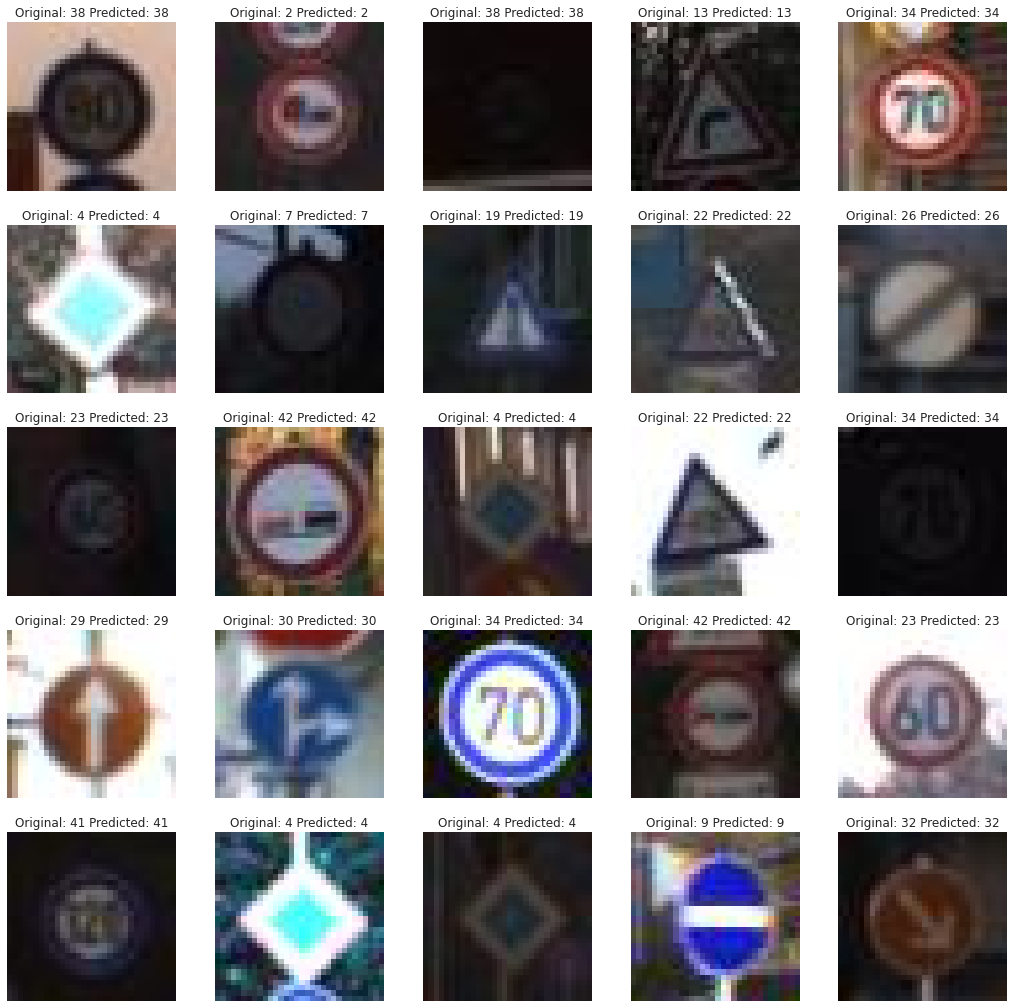

In [32]:
fig, axes = plt.subplots(5,5, figsize=(18,18))
for i,ax in enumerate(axes.flat):
    r = np.random.randint(X_test.shape[0])
    ax.imshow(X_test[r].astype('uint8'))
    ax.grid(False)
    ax.axis('off')
    ax.set_title('Original: {} Predicted: {}'.format(np.argmax(y_test[r]), np.argmax(model.predict(X_test[r].reshape(1, 32, 32, 3)))))

--- 